Figure 3.b (of the original manuscript)
>> histogram distribution of QAOA on 4-body interacting solution

In [1]:
!pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 5.2 MB/s eta 0:00:00


In [2]:
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 53.1 MB/s eta 0:00:00


In [3]:
## FUNCTION DEFINITION
#-----------------------------------------------
# solve order-2 hadamard, 2-unknown variables
# [1 s1; s2 s3]
# => E=2( 1 + s1*s2*s3*s4)
#-----------------------------------------------


#-- MIXING UNITARY
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
#from qiskit import Aer, execute
from qiskit_aer import Aer #, execute
from qiskit.circuit import Parameter

nqubits = 4 #3-body case

# -- QAOA LOOP

def had2_4body_obj(vs):
    # value of objective function
    # actually it is not maxcut obj, but had2_obj
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.

    Args:
        x: str
           solution bitstring

    Returns:
        obj: float
             Objective
    """
    # convert binary {0,1} -> spin {-1, +1}
    def b2s(x):
        if (x<1):
            s= 1.0
        if (x>0):
            s= -1.0
        return s

    obj=2*(1+ b2s(int(vs[0]))*b2s(int(vs[1]))*b2s(int(vs[2]))*b2s(int(vs[3])))
    # --
    return obj


def compute_expectation(counts):

    """
    Computes expectation value based on measurement results

    Args:
        counts: dict
                key as bitstring, val as count

    Returns:
        avg: float
             expectation value
    """

    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():

        obj = had2_4body_obj(bitstring)
        avg += obj * count
        sum_count += count

    return avg/sum_count

# -- 4-body --
def U_C_4body(qc, c, gamma, qbs):
    qc.cx(qbs[0], qbs[1])
    qc.cx(qbs[1], qbs[2])
    qc.cx(qbs[2], qbs[3])
    #
    qc.rz(2*c*gamma, qbs[3])
    #
    qc.cx(qbs[2], qbs[3])
    qc.cx(qbs[1], qbs[2])
    qc.cx(qbs[0], qbs[1])
# --

# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(n_qubits, theta):

    """
    Creates a parametrized qaoa circuit

    Args:
        theta: list
               unitary parameters

    Returns:
        qc: qiskit circuit
    """

    nqubits = n_qubits # len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    qc = QuantumCircuit(nqubits)
    #--
    beta = theta[:p]
    gamma = theta[p:]

    # initial_state
    for i in range(0, nqubits):
        qc.h(i)
    qbs=[0,1,2,3]
    for irep in range(0, p):

        # problem unitary
        #U_C_4body(qc, 1, gamma, qbs)
        U_C_4body(qc, 1, gamma[irep], qbs)

        #qc.cx(0,1)
        #qc.cx(1,2)
        #qc.rz(2*gamma[irep], 2)
        #qc.cx(1,2)
        #qc.cx(0,1)

        # mixer unitary
        qc.barrier()
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
    #--
    qc.measure_all()
    return qc

# Finally we write a function that executes the circuit on the chosen backend

def get_expectation(p, shots=512):

    """
    Runs parametrized circuit

    Args:
        p: int,
           Number of repetitions of unitaries
    """

    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    def execute_circ(theta):

        qc = create_qaoa_circ(nqubits,theta)
        #--
        #print(qc.draw())
        # --
        counts = backend.run(qc, seed_simulator=10,
                             nshots=512).result().get_counts()
        return compute_expectation(counts)

    return execute_circ
#

In [4]:
##########################################################################
# MAIN START
##########################################################################

from scipy.optimize import minimize
import matplotlib.pyplot as plt

expectation = get_expectation(p=1)

res = minimize(expectation, [1.0, 1.0], method='COBYLA')
print(res)

#--
#-- DISPLAY RESULTS
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
#backend = Aer.get_backend('qasm_simulator')
backend.shots = 512

qc_res = create_qaoa_circ(nqubits, res.x)

#qc_res.draw('mpl') ## for documents/ppr
print(qc_res.draw())


counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

#plot_histogram(counts)
#plt.show()

import matplotlib.pyplot as plt


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 0.00390625
       x: [ 2.943e+00  7.335e-01]
    nfev: 24
   maxcv: 0.0
        ┌───┐                                             ░ ┌───────────┐ ░ ┌─┐»
   q_0: ┤ H ├──■──────────────────────────────────────■───░─┤ Rx(5.887) ├─░─┤M├»
        ├───┤┌─┴─┐                                  ┌─┴─┐ ░ ├───────────┤ ░ └╥┘»
   q_1: ┤ H ├┤ X ├──■────────────────────────────■──┤ X ├─░─┤ Rx(5.887) ├─░──╫─»
        ├───┤└───┘┌─┴─┐                        ┌─┴─┐└───┘ ░ ├───────────┤ ░  ║ »
   q_2: ┤ H ├─────┤ X ├──■──────────────────■──┤ X ├──────░─┤ Rx(5.887) ├─░──╫─»
        ├───┤     └───┘┌─┴─┐┌────────────┐┌─┴─┐└───┘      ░ ├───────────┤ ░  ║ »
   q_3: ┤ H ├──────────┤ X ├┤ Rz(1.4671) ├┤ X ├───────────░─┤ Rx(5.887) ├─░──╫─»
        └───┘          └───┘└────────────┘└───┘           ░ └───────────┘ ░  ║ »
meas: 4/═════════════════════════════════════════════════════════════════════╩═»
                                 

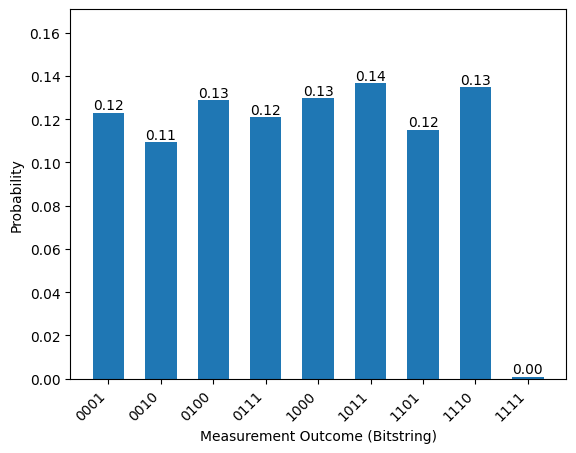

In [6]:
# Total shots
total = sum(counts.values())

# Sort the labels
sorted_labels = sorted(counts.keys())

# Get probabilities in sorted order
probs = [counts[label] / total for label in sorted_labels]

# Plot
plt.bar(sorted_labels, probs, width=0.6)

# Label the axes
plt.xlabel('Measurement Outcome (Bitstring)')
plt.ylabel('Probability')
#plt.title('Measurement Results')
plt.ylim(0, 1.25*max(probs))
#plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')  # rotate 45 derajat dan rata kanan

# Add text labels on top of bars
for i in range(len(sorted_labels)):
    plt.text(sorted_labels[i], probs[i] + 0*0.02, f'{probs[i]:.2f}',
             ha='center', va='bottom', fontsize=10)

In [ ]:
max(probs)


0.13671875